In [1]:
import warnings
warnings.filterwarnings('ignore')
import gc
import ctypes
import os
import itertools
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
import pprint
import time
import copy
import lightgbm as lgb
import torch
import polars as pl
import optuna

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression,Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error,mean_squared_error,accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, PowerTransformer, RobustScaler, FunctionTransformer
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn import metrics
%matplotlib inline
from random import choice, choices
from functools import reduce, partial
from tqdm import tqdm
from itertools import cycle
from collections import Counter
from scipy import stats
from scipy.stats import skew, kurtosis
from transformers import BertTokenizer
from collections import Counter, defaultdict
from tqdm.autonotebook import tqdm
from math import sqrt
from sklearn import model_selection

def clean_memory():
    gc.collect()
    ctypes.CDLL("libc.so.6").malloc_trim(0)
    torch.cuda.empty_cache()
clean_memory()

In [2]:
!pip install /kaggle/input/tabpfn-019-whl/tabpfn-0.1.9-py3-none-any.whl
!mkdir /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/tabpfn-019-whl/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Processing /kaggle/input/tabpfn-019-whl/tabpfn-0.1.9-py3-none-any.whl


In [3]:
def reconstruct_essay(currTextInput):
    essayText = ""
    for Input in currTextInput.values:
        if Input[0] == 'Replace':
            replaceTxt = Input[2].split(' => ')
            essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
            continue
        if Input[0] == 'Paste':
            essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
            continue
        if Input[0] == 'Remove/Cut':
            essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
            continue
        if "M" in Input[0]:
            croppedTxt = Input[0][10:]
            splitTxt = croppedTxt.split(' To ')
            valueArr = [item.split(', ') for item in splitTxt]
            moveData = (int(valueArr[0][0][1:]), int(valueArr[0][1][:-1]), int(valueArr[1][0][1:]), int(valueArr[1][1][:-1]))
            if moveData[0] != moveData[2]:
                if moveData[0] < moveData[2]:
                    essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                else:
                    essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
            continue
        essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
    return essayText


def get_essay_df(df):
    df       = df[df.activity != 'Nonproduction']
    temp     = df.groupby('id').apply(lambda x: reconstruct_essay(x[['activity', 'cursor_position', 'text_change']]))
    essay_df = pd.DataFrame({'id': df['id'].unique().tolist()})
    essay_df = essay_df.merge(temp.rename('essay'), on='id')
    return essay_df

In [4]:
traindf = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv')
train_scores = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')
testdf = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv')

In [5]:
%%time
train_essays = get_essay_df(traindf)

CPU times: user 20 s, sys: 637 ms, total: 20.6 s
Wall time: 20.6 s


In [6]:
%%time
test_essays = get_essay_df(testdf)

CPU times: user 6.33 ms, sys: 148 µs, total: 6.48 ms
Wall time: 6.09 ms


In [7]:
train_essaysdf = pd.DataFrame({'id': train_essays.id, 'essay': train_essays.essay})
test_essaysdf = pd.DataFrame({'id': test_essays.id, 'essay': test_essays.essay})

merged_data = train_essaysdf.merge(train_scores, on='id')

In [8]:
merged_data

,id,essay,score
0,001519c8,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...,3.5
1,0022f953,"qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq...",3.5
2,0042269b,qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...,6.0
3,0059420b,qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...,2.0
4,0075873a,"qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq...",4.0
...,...,...,...
2466,ffb8c745,"qq qqqqq'q qqqqqqq, qqq'q qqqqq q qqqq qq...",3.5
2467,ffbef7e5,"qqqq qqqqqq qqqqq qq qqqqq qqqqq, qq qq q qqqq...",4.0
2468,ffccd6fd,qqqqqq qqqq q qqqqqqq qqqqqqqqq qq qqqqqq qqqq...,1.5
2469,ffec5b38,"qqqqqqqqqq qqqqqqq, qqqqqq qqqq qqqqq qqqq qqq...",5.0


In [9]:
#단어와 단어의 연속된 조합(단어 n-그램)을 추출하고, 이를 기반으로 텍스트 데이터를 벡터 형태로 변환
#X_tokenizer_train과 X_tokenizer_test에는 학습 및 테스트 데이터에 대한 단어 빈도 벡터가 저장
#y는 target value score
count_vectorizer = CountVectorizer(ngram_range=(1, 4), analyzer='char_wb')
X_tokenizer_train = count_vectorizer.fit_transform(merged_data['essay'])
X_tokenizer_test = count_vectorizer.transform(test_essaysdf['essay'])
count_vectorizer.get_feature_names_out() #ADDED
y = merged_data['score']

In [10]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [11]:
# 메모리 요구사항 증가 but, 연산 수행시 효과적: dense 행렬 변환
X_tokenizer_train = X_tokenizer_train.todense()
X_tokenizer_test = X_tokenizer_test.todense()

for i in range(X_tokenizer_train.shape[1]) : 
    L = list(X_tokenizer_train[:,i])
    li = [int(x) for x in L ]
    df_train[f'feature {i}'] = li
    
for i in range(X_tokenizer_test.shape[1]) : 
    L = list(X_tokenizer_test[:,i])
    li = [int(x) for x in L ]
    df_test[f'feature {i}'] = li    

In [12]:
df_train_index = train_essaysdf['id']
df_test_index = test_essaysdf['id']

# id 열 추가 
df_train.loc[:, 'id'] = df_train_index
df_test.loc[:, 'id'] = df_test_index

# Modified XGB

In [13]:
import polars as pl
import pandas as pd
import numpy as np
import re
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold, KFold
from scipy.stats import skew, kurtosis
import warnings
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [14]:
num_cols = ['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']
activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
text_changes = ['q', ' ', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']


def count_by_values(df, colname, values):
    fts = df.select(pl.col('id').unique(maintain_order=True))
    for i, value in enumerate(values):
        tmp_df = df.group_by('id').agg(pl.col(colname).is_in([value]).sum().alias(f'{colname}_{i}_cnt'))
        fts  = fts.join(tmp_df, on='id', how='left') 
    return fts


def dev_feats(df):
    
    print("< Count by values features >")
    
    feats = count_by_values(df, 'activity', activities)
    feats = feats.join(count_by_values(df, 'text_change', text_changes), on='id', how='left') 
    feats = feats.join(count_by_values(df, 'down_event', events), on='id', how='left') 
    feats = feats.join(count_by_values(df, 'up_event', events), on='id', how='left') 

    print("< Input words stats features >")

    temp = df.filter((~pl.col('text_change').str.contains('=>')) & (pl.col('text_change') != 'NoChange'))
    temp = temp.group_by('id').agg(pl.col('text_change').str.concat('').str.extract_all(r'q+'))
    temp = temp.with_columns(input_word_count = pl.col('text_change').list.lengths(),
                             input_word_length_mean = pl.col('text_change').apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_max = pl.col('text_change').apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_std = pl.col('text_change').apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_median = pl.col('text_change').apply(lambda x: np.median([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_skew = pl.col('text_change').apply(lambda x: skew([len(i) for i in x] if len(x) > 0 else 0)))
    temp = temp.drop('text_change')
    feats = feats.join(temp, on='id', how='left') 


    
    print("< Numerical columns features >")

    temp = df.group_by("id").agg(pl.sum('action_time').suffix('_sum'), pl.mean(num_cols).suffix('_mean'), pl.std(num_cols).suffix('_std'),
                                 pl.median(num_cols).suffix('_median'), pl.min(num_cols).suffix('_min'), pl.max(num_cols).suffix('_max'),
                                 pl.quantile(num_cols, 0.5).suffix('_quantile'))
    feats = feats.join(temp, on='id', how='left') 


    print("< Categorical columns features >")
    
    temp  = df.group_by("id").agg(pl.n_unique(['activity', 'down_event', 'up_event', 'text_change']))
    feats = feats.join(temp, on='id', how='left') 


    
    print("< Idle time features >")

    temp = df.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
    temp = temp.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
    temp = temp.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    temp = temp.group_by("id").agg(inter_key_largest_lantency = pl.max('time_diff'),
                                   inter_key_median_lantency = pl.median('time_diff'),
                                   mean_pause_time = pl.mean('time_diff'),
                                   std_pause_time = pl.std('time_diff'),
                                   total_pause_time = pl.sum('time_diff'),
                                   pauses_half_sec = pl.col('time_diff').filter((pl.col('time_diff') > 0.5) & (pl.col('time_diff') < 1)).count(),
                                   pauses_1_sec = pl.col('time_diff').filter((pl.col('time_diff') > 1) & (pl.col('time_diff') < 1.5)).count(),
                                   pauses_1_half_sec = pl.col('time_diff').filter((pl.col('time_diff') > 1.5) & (pl.col('time_diff') < 2)).count(),
                                   pauses_2_sec = pl.col('time_diff').filter((pl.col('time_diff') > 2) & (pl.col('time_diff') < 3)).count(),
                                   pauses_3_sec = pl.col('time_diff').filter(pl.col('time_diff') > 3).count(),)
    feats = feats.join(temp, on='id', how='left') 
    
    print("< P-bursts features >")

    temp = df.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
    temp = temp.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
    temp = temp.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    temp = temp.with_columns(pl.col('time_diff')<2)
    temp = temp.with_columns(pl.when(pl.col("time_diff") & pl.col("time_diff").is_last()).then(pl.count()).over(pl.col("time_diff").rle_id()).alias('P-bursts'))
    temp = temp.drop_nulls()
    temp = temp.group_by("id").agg(pl.mean('P-bursts').suffix('_mean'), pl.std('P-bursts').suffix('_std'), pl.count('P-bursts').suffix('_count'),
                                   pl.median('P-bursts').suffix('_median'), pl.max('P-bursts').suffix('_max'),
                                   pl.first('P-bursts').suffix('_first'), pl.last('P-bursts').suffix('_last'))
    feats = feats.join(temp, on='id', how='left') 


    print("< R-bursts features >")

    temp = df.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    temp = temp.with_columns(pl.col('activity').is_in(['Remove/Cut']))
    temp = temp.with_columns(pl.when(pl.col("activity") & pl.col("activity").is_last()).then(pl.count()).over(pl.col("activity").rle_id()).alias('R-bursts'))
    temp = temp.drop_nulls()
    temp = temp.group_by("id").agg(pl.mean('R-bursts').suffix('_mean'), pl.std('R-bursts').suffix('_std'), 
                                   pl.median('R-bursts').suffix('_median'), pl.max('R-bursts').suffix('_max'),
                                   pl.first('R-bursts').suffix('_first'), pl.last('R-bursts').suffix('_last'))
    feats = feats.join(temp, on='id', how='left')
    
    return feats


In [15]:
def q1(x):
    return x.quantile(0.1)
def q2(x):
    return x.quantile(0.25)
def q7(x):
    return x.quantile(0.75)
def q9(x):
    return x.quantile(0.90)

AGGREGATIONS = ['count', 'mean', 'min', 'max', 'first', 'last', q2, 'median', q7,'sum']

def reconstruct_essay(currTextInput):
    essayText = ""
    for Input in currTextInput.values:
        if Input[0] == 'Replace':
            replaceTxt = Input[2].split(' => ')
            essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
            continue
        if Input[0] == 'Paste':
            essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
            continue
        if Input[0] == 'Remove/Cut':
            essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
            continue
        if "M" in Input[0]:
            croppedTxt = Input[0][10:]
            splitTxt = croppedTxt.split(' To ')
            valueArr = [item.split(', ') for item in splitTxt]
            moveData = (int(valueArr[0][0][1:]), int(valueArr[0][1][:-1]), int(valueArr[1][0][1:]), int(valueArr[1][1][:-1]))
            if moveData[0] != moveData[2]:
                if moveData[0] < moveData[2]:
                    essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                else:
                    essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
            continue
        essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
    return essayText


def get_essay_df(df):
    df       = df[df.activity != 'Nonproduction']
    temp     = df.groupby('id').apply(lambda x: reconstruct_essay(x[['activity', 'cursor_position', 'text_change']]))
    essay_df = pd.DataFrame({'id': df['id'].unique().tolist()})
    essay_df = essay_df.merge(temp.rename('essay'), on='id')
    return essay_df


def word_feats(df):
    essay_df = df
    df['word'] = df['essay'].apply(lambda x: re.split(' |\\n|\\.|\\?|\\!',x))
    df = df.explode('word')
    df['word_len'] = df['word'].apply(lambda x: len(x))
    df = df[df['word_len'] != 0]

    word_agg_df = df[['id','word_len']].groupby(['id']).agg(AGGREGATIONS)
    word_agg_df.columns = ['_'.join(x) for x in word_agg_df.columns]
    word_agg_df['id'] = word_agg_df.index
    word_agg_df = word_agg_df.reset_index(drop=True)
    return word_agg_df


def sent_feats(df):
    df['sent'] = df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',x))
    df = df.explode('sent')
    df['sent'] = df['sent'].apply(lambda x: x.replace('\n','').strip())
    # Number of characters in sentences
    df['sent_len'] = df['sent'].apply(lambda x: len(x))
    # Number of words in sentences
    df['sent_word_count'] = df['sent'].apply(lambda x: len(x.split(' ')))
    df = df[df.sent_len!=0].reset_index(drop=True)

    sent_agg_df = pd.concat([df[['id','sent_len']].groupby(['id']).agg(AGGREGATIONS), 
                             df[['id','sent_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1)
    sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
    sent_agg_df['id'] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
    return sent_agg_df


def parag_feats(df):
    df['paragraph'] = df['essay'].apply(lambda x: x.split('\n'))
    df = df.explode('paragraph')
    # Number of characters in paragraphs
    df['paragraph_len'] = df['paragraph'].apply(lambda x: len(x)) 
    # Number of words in paragraphs
    df['paragraph_word_count'] = df['paragraph'].apply(lambda x: len(x.split(' ')))
    df = df[df.paragraph_len!=0].reset_index(drop=True)
    
    paragraph_agg_df = pd.concat([df[['id','paragraph_len']].groupby(['id']).agg(AGGREGATIONS), 
                                  df[['id','paragraph_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1) 
    paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df['id'] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
    return paragraph_agg_df

def product_to_keys(logs, essays):
    essays['product_len'] = essays.essay.str.len()
    tmp_df = logs[logs.activity.isin(['Input', 'Remove/Cut'])].groupby(['id']).agg({'activity': 'count'}).reset_index().rename(columns={'activity': 'keys_pressed'})
    essays = essays.merge(tmp_df, on='id', how='left')
    essays['product_to_keys'] = essays['product_len'] / essays['keys_pressed']
    return essays[['id', 'product_to_keys']]

def get_keys_pressed_per_second(logs):
    temp_df = logs[logs['activity'].isin(['Input', 'Remove/Cut'])].groupby(['id']).agg(keys_pressed=('event_id', 'count')).reset_index()
    temp_df_2 = logs.groupby(['id']).agg(min_down_time=('down_time', 'min'), max_up_time=('up_time', 'max')).reset_index()
    temp_df = temp_df.merge(temp_df_2, on='id', how='left')
    temp_df['keys_per_second'] = temp_df['keys_pressed'] / ((temp_df['max_up_time'] - temp_df['min_down_time']) / 1000)
    return temp_df[['id', 'keys_per_second']]


def target_encoding(train_df, scores, feature):
    
    train_df['target'] = train_df['id'].map(dict(scores.values))
    
    down_event_counts = train_df[feature].value_counts()
    rare_down_events = down_event_counts[down_event_counts <= 3].index
    # Replace 'target' values with NaN for these rare events
    train_df.loc[train_df[feature].isin(rare_down_events), 'target'] = np.nan    

    # Step 2: Calculate the mean 'target' for each 'down_event'
    mean_target_by_down_event = train_df.groupby(feature)['target'].mean().reset_index(name=f'{feature}_mean_target')
    train_df.drop(columns=["target"], inplace=True)
    
    return mean_target_by_down_event

In [16]:
print('< Read Data >')
data_path     = '/kaggle/input/linking-writing-processes-to-writing-quality/'
# Train
train_logs    = pl.scan_csv(data_path + 'train_logs.csv')
train_feats   = dev_feats(train_logs)
train_feats   = train_feats.collect().to_pandas()
train_scores   = pd.read_csv(data_path + 'train_scores.csv')
train_logs             = train_logs.collect().to_pandas().drop([850340],axis=0)
# Test
test_logs   = pl.scan_csv(data_path + 'test_logs.csv')
test_feats  = dev_feats(test_logs)
test_feats  = test_feats.collect().to_pandas()
test_logs             = test_logs.collect().to_pandas()

print('< Train Features >')
train_essays           = get_essay_df(train_logs)
train_feats            = train_feats.merge(word_feats(train_essays), on='id', how='left')
train_feats            = train_feats.merge(sent_feats(train_essays), on='id', how='left')
train_feats            = train_feats.merge(parag_feats(train_essays), on='id', how='left')
train_feats            = train_feats.merge(get_keys_pressed_per_second(train_logs), on='id', how='left')
train_feats            = train_feats.merge(product_to_keys(train_logs, train_essays), on='id', how='left')

# new
train_feats            = train_feats.merge(df_train,on='id', how='left')
    

print('< Train Features >')
test_essays           = get_essay_df(test_logs)
test_feats            = test_feats.merge(word_feats(test_essays), on='id', how='left')
test_feats            = test_feats.merge(sent_feats(test_essays), on='id', how='left')
test_feats            = test_feats.merge(parag_feats(test_essays), on='id', how='left')
test_feats            = test_feats.merge(get_keys_pressed_per_second(test_logs), on='id', how='left')
test_feats            = test_feats.merge(product_to_keys(test_logs, test_essays), on='id', how='left')

# new
test_feats            = test_feats.merge(df_test,on='id', how='left')


print('Finished!!!!')

< Read Data >
< Count by values features >
< Input words stats features >
< Numerical columns features >
< Categorical columns features >
< Idle time features >
< P-bursts features >
< R-bursts features >
< Count by values features >
< Input words stats features >
< Numerical columns features >
< Categorical columns features >
< Idle time features >
< P-bursts features >
< R-bursts features >
< Train Features >
< Train Features >
Finished!!!!


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
CouVec = CountVectorizer(stop_words='english')
df = pd.concat([train_essays,test_essays])
CouVec.fit(df['essay'])
train_words = pd.DataFrame(CouVec.transform(train_essays['essay']).toarray())
test_words = pd.DataFrame(CouVec.transform(test_essays['essay']).toarray())

from sklearn.decomposition import LatentDirichletAllocation
n_clusters = 6
LDA = LatentDirichletAllocation(n_components=n_clusters, max_iter=10, random_state=42, verbose=True)
LDA.fit(pd.concat([train_words,test_words]))
Topics = [f'Topic_{x}' for x in range(0,n_clusters)]
train_feats[Topics] = LDA.transform(train_words)
test_feats[Topics] = LDA.transform(test_words)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
CouVec = CountVectorizer(analyzer='char_wb')
df = pd.concat([train_essays,test_essays])
CouVec.fit(df['essay'])
train_words = pd.DataFrame(CouVec.transform(train_essays['essay']).toarray())
test_words = pd.DataFrame(CouVec.transform(test_essays['essay']).toarray())

from sklearn.decomposition import LatentDirichletAllocation
n_clusters = 6
LDA = LatentDirichletAllocation(n_components=n_clusters, max_iter=10, random_state=42, verbose=True)
LDA.fit(pd.concat([train_words,test_words]))
Topics = [f'_Topic_{x}' for x in range(0,n_clusters)]
train_feats[Topics] = LDA.transform(train_words)
test_feats[Topics] = LDA.transform(test_words)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
CouVec = CountVectorizer(analyzer='char_wb',ngram_range=(5, 6))
df = pd.concat([train_essays,test_essays])
CouVec.fit(df['essay'])
train_words = pd.DataFrame(CouVec.transform(train_essays['essay']).toarray())
test_words = pd.DataFrame(CouVec.transform(test_essays['essay']).toarray())

from sklearn.decomposition import LatentDirichletAllocation
n_clusters = 6
LDA = LatentDirichletAllocation(n_components=n_clusters, max_iter=10, random_state=42, verbose=True)
LDA.fit(pd.concat([train_words,test_words]))
Topics = [f'__Topic_{x}' for x in range(0,n_clusters)]
train_feats[Topics] = LDA.transform(train_words)
test_feats[Topics] = LDA.transform(test_words)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [20]:
feats = ['paragraph_count',
 'inter_key_median_lantency',
 'feature 1048',
 'feature 1049',
 'feature 1120',
 'feature 448',
 'feature 449',
 'feature 846',
 'feature 847',
 'feature 65',
 'feature 138',
 'feature 141',
 'text_change_7_cnt',
 'sent_word_count_median',
 'feature 1023',
 'feature 1031',
 'feature 335',
 'feature 364',
 'feature 365',
 'feature 789',
 'feature 808',
 'feature 809',
 'R-bursts_median',
 'Topic_4',
 'cursor_position_max',
 'feature 0',
 'feature 1108',
 'feature 1109',
 'feature 1130',
 'feature 126',
 'feature 168',
 'feature 185',
 'feature 719',
 'feature 720',
 'feature 992',
 'feature 993',
 'paragraph_len_sum',
 'sent_len_sum',
 'sent_word_count_sum',
 'word_count_max',
 'word_count_std',
 'word_len_count',
 'word_len_sum',
 'action_time_max',
 'down_event_3_cnt',
 'up_event_3_cnt',
 'pauses_1_half_sec',
 'paragraph_word_count_q2',
 'product_to_keys',
 'paragraph_len_max',
 'text_change_6_cnt',
 'feature 1124',
 'feature 580',
 'feature 200',
 'feature 721',
 'feature 994',
 'feature 180',
 'feature 556',
 'mean_pause_time',
 'cursor_position_std',
 'word_len_q2',
 'sent_word_count_q2',
 'text_change_8_cnt',
 'feature 905',
 'feature 1115',
 'feature 913',
 'feature 288',
 'sent_word_count_q7',
 'feature 179',
 'feature 47',
 'feature 55',
 'feature 908',
 'text_change',
 'paragraph_word_count_q7',
 'down_event_12_cnt',
 'up_event_12_cnt',
 'feature 376',
 'feature 377',
 'feature 814',
 'feature 76',
 'feature 1075',
 'feature 1079',
 'feature 605',
 'feature 614',
 'feature 622',
 'feature 923',
 'feature 929',
 'feature 934',
 'action_time_std',
 'feature 480',
 'sent_word_count_first',
 'sent_len_q2',
 'feature 319',
 'text_change_12_cnt',
 'activity_1_cnt',
 'down_event_2_cnt',
 'up_event_2_cnt',
 'feature 38',
 'feature 43',
 'feature 46',
 'feature 9',
 'word_len_q7',
 'feature 336',
 'paragraph_len_first',
 'activity_3_cnt',
 'feature 1063',
 'feature 521',
 'feature 522',
 'feature 882',
 'feature 883',
 'feature 594',
 'feature 1035',
 'feature 1117',
 'feature 823',
 'feature 587',
 'sent_len_mean',
 'feature 893',
 'feature 572',
 'feature 1003',
 'feature 741',
 'text_change_11_cnt',
 'feature 1080',
 'feature 1081',
 'feature 629',
 'feature 630',
 'feature 935',
 'feature 936',
 'keys_per_second',
 'activity_0_cnt',
 'down_event_0_cnt',
 'text_change_0_cnt',
 'up_event_0_cnt',
 'down_event_10_cnt',
 'up_event_10_cnt',
 'feature 162',
 'feature 163',
 'feature 557',
 'feature 92',
 'feature 95',
 'feature 14',
 'feature 19',
 'feature 235',
 'feature 267',
 'feature 276',
 'feature 8',
 'feature 1002',
 'feature 1111',
 'feature 740',
 'word_len_median',
 'sent_len_median',
 'feature 252',
 'feature 253',
 'feature 593',
 'feature 722',
 'feature 995',
 'feature 544',
 'text_change_10_cnt',
 'feature 508',
 'feature 778',
 'paragraph_word_count_min',
 'feature 72',
 'feature 75',
 'R-bursts_std',
 'feature 384',
 'feature 817',
 'feature 388',
 'feature 897',
 'feature 539',
 'feature 1055',
 'feature 863',
 'feature 1066',
 'std_pause_time',
 'input_word_length_mean',
 'paragraph_len_min',
 'feature 389',
 'feature 400',
 'feature 418',
 'feature 894',
 'feature 79',
 'feature 1123',
 'feature 170',
 'feature 78',
 'Topic_2',
 'total_pause_time',
 'down_event_13_cnt',
 'text_change_5_cnt',
 'up_event_13_cnt',
 'pauses_3_sec',
 'word_len_max',
 'P-bursts_count',
 'feature 481',
 'sent_word_count_mean',
 'Topic_3',
 'feature 1020',
 'feature 1021',
 'feature 419',
 'feature 152',
 'feature 153',
 'feature 566',
 'feature 84',
 'feature 284',
 'input_word_count',
 'feature 410',
 'feature 60',
 'sent_len_first',
 'feature 181',
 'feature 417',
 'word_count_mean',
 'word_count_median',
 'word_count_quantile',
 'feature 383',
 'feature 918',
 'word_len_mean',
 'down_event_9_cnt',
 'up_event_9_cnt',
 'feature 173',
 'feature 1121',
 'P-bursts_last',
 'word_len_min',
 'feature 1061',
 'feature 1122',
 'feature 519',
 'feature 880',
 'feature 85',
 'feature 499',
 'feature 507',
 'feature 515',
 'paragraph_word_count_mean',
 'feature 898',
 'word_len_first',
 'input_word_length_max',
 'feature 178',
 'feature 1059',
 'feature 873',
 'feature 877',
 'paragraph_word_count_max',
 'feature 184',
 'text_change_9_cnt',
 'feature 174',
 'paragraph_len_median',
 'down_event_1_cnt',
 'text_change_1_cnt',
 'up_event_1_cnt',
 'feature 1036',
 'action_time_sum',
 'down_event_14_cnt',
 'up_event_14_cnt',
 'feature 1091',
 'feature 1092',
 'feature 1127',
 'feature 665',
 'feature 666',
 'feature 954',
 'feature 955',
 'input_word_length_std',
 'sent_len_q7',
 'down_event_8_cnt',
 'text_change_3_cnt',
 'up_event_8_cnt',
 'down_time_min',
 'up_time_min',
 'feature 598',
 'feature 503',
 'feature 504',
 'feature 876',
 'R-bursts_mean',
 'feature 1072',
 'paragraph_word_count_last',
 'activity_2_cnt',
 'down_time_std',
 'up_time_std',
 'feature 1024',
 'feature 790',
 'Topic_5',
 'paragraph_word_count_sum',
 'paragraph_word_count_first',
 'pauses_1_sec',
 'R-bursts_max',
 'inter_key_largest_lantency',
 'paragraph_len_q7',
 'pauses_2_sec',
 'paragraph_len_mean',
 'cursor_position_mean',
 'cursor_position_median',
 'cursor_position_quantile',
 'feature 1062',
 'feature 520',
 'feature 881',
 'down_event',
 'up_event',
 'down_event_11_cnt',
 'up_event_11_cnt',
 'paragraph_len_q2',
 'paragraph_word_count_median',
 'feature 127',
 'text_change_4_cnt',
 'paragraph_len_last',
 'down_event_4_cnt',
 'up_event_4_cnt',
 'feature 169',
 'Topic_0'] + ['_Topic_0','_Topic_1','_Topic_2','_Topic_3','_Topic_4','_Topic_5'] + [f'__Topic_{x}' for x in range(6)] 

In [21]:
print('< Mapping >')

## Train
train_scores   = pd.read_csv(data_path + 'train_scores.csv')
data           = train_feats.merge(train_scores, on='id', how='left')
x              = data.drop(['id', 'score'], axis=1)[feats]
y              = data['score'].values
print(f'Number of features: {len(x.columns)}')

## Test
test_ids = test_feats['id'].values
testin_x = test_feats.drop(['id'], axis=1)[feats]

< Mapping >
Number of features: 313


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2474 samples in 0.002s...
[t-SNE] Computed neighbors for 2474 samples in 0.252s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2474
[t-SNE] Computed conditional probabilities for sample 2000 / 2474
[t-SNE] Computed conditional probabilities for sample 2474 / 2474
[t-SNE] Mean sigma: 22768.628429
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.835045
[t-SNE] KL divergence after 1000 iterations: 0.896006


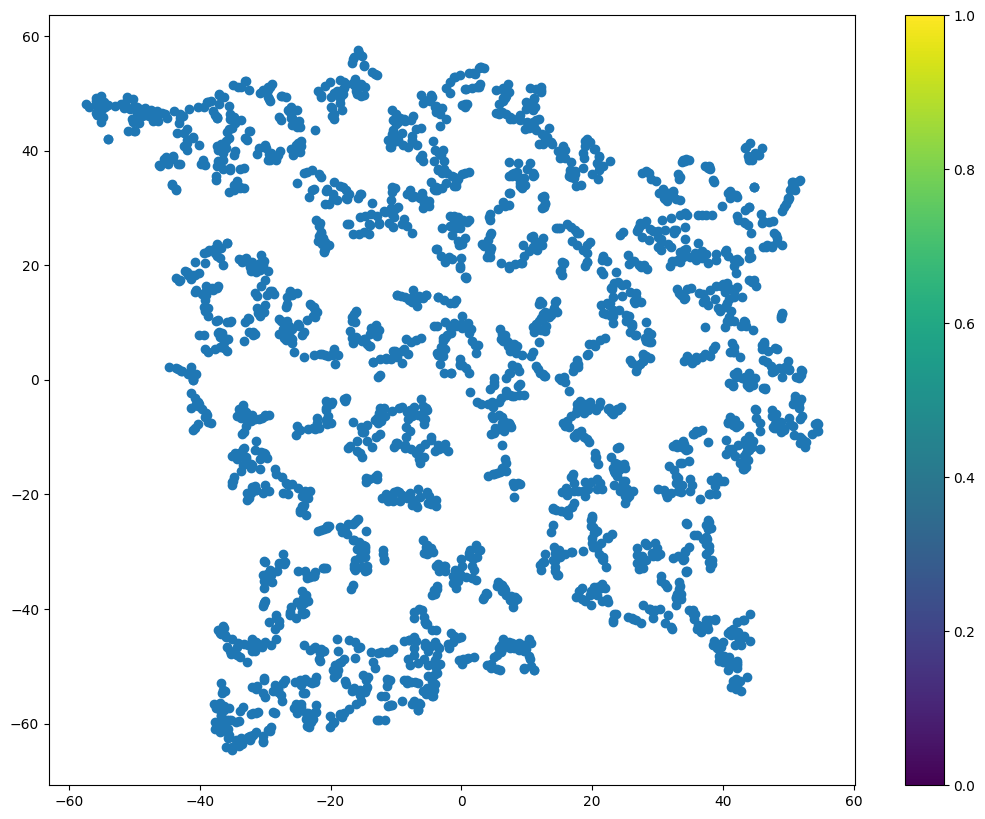

In [22]:
from sklearn.manifold import TSNE
#For Features Adding
df = pd.concat([x[feats],testin_x[feats]])

t_sne = TSNE(n_components=2, random_state=42, perplexity=20, n_jobs=-1, verbose=True)
df_tsne = t_sne.fit_transform(df.fillna(0))

plt.figure(figsize=(13,10))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], cmap="jet")
plt.colorbar()
plt.show()

x['tsne_0'] = df_tsne[:x.shape[0],0]
x['tsne_1'] = df_tsne[:x.shape[0],1]

testin_x['tsne_0'] = df_tsne[x.shape[0]:,0]
testin_x['tsne_1'] = df_tsne[x.shape[0]:,1]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2474 samples in 0.002s...
[t-SNE] Computed neighbors for 2474 samples in 0.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2474
[t-SNE] Computed conditional probabilities for sample 2000 / 2474
[t-SNE] Computed conditional probabilities for sample 2474 / 2474
[t-SNE] Mean sigma: 32473.397530
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.542206
[t-SNE] KL divergence after 1000 iterations: 0.809071


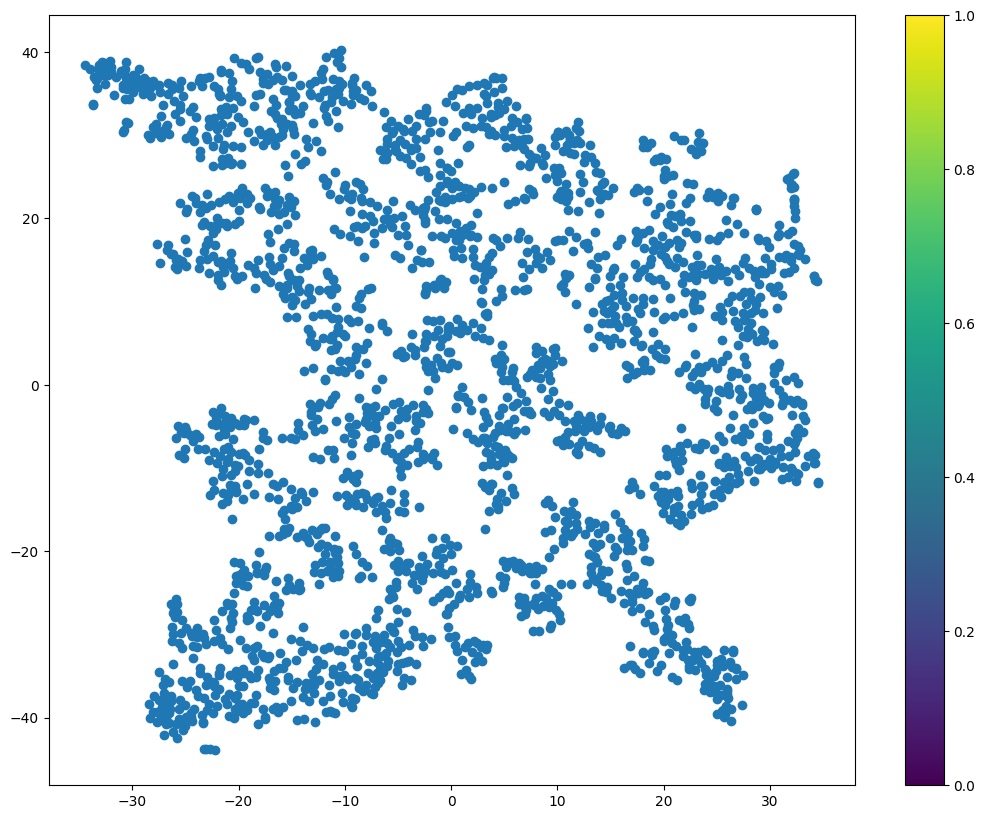

In [23]:
from sklearn.manifold import TSNE
#For Features Adding
df = pd.concat([x[feats],testin_x[feats]])

t_sne = TSNE(n_components=2, random_state=42, perplexity=50, n_jobs=-1, verbose=True)
df_tsne = t_sne.fit_transform(df.fillna(0))

plt.figure(figsize=(13,10))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], cmap="jet")
plt.colorbar()
plt.show()

x['_tsne_0'] = df_tsne[:x.shape[0],0]
x['_tsne_1'] = df_tsne[:x.shape[0],1]

testin_x['_tsne_0'] = df_tsne[x.shape[0]:,0]
testin_x['_tsne_1'] = df_tsne[x.shape[0]:,1]

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 2474 samples in 0.002s...
[t-SNE] Computed neighbors for 2474 samples in 0.171s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2474
[t-SNE] Computed conditional probabilities for sample 2000 / 2474
[t-SNE] Computed conditional probabilities for sample 2474 / 2474
[t-SNE] Mean sigma: 38989.599725
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.448112
[t-SNE] KL divergence after 1000 iterations: 0.730261


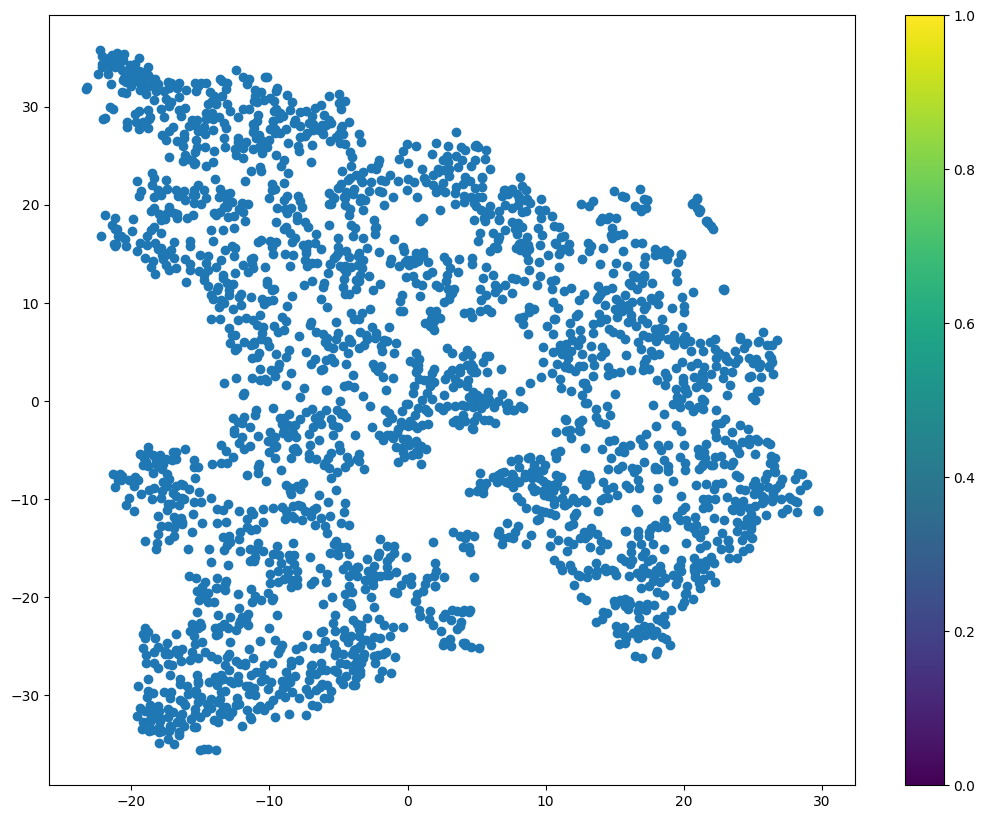

In [24]:
from sklearn.manifold import TSNE
#For Features Adding
df = pd.concat([x[feats],testin_x[feats]])

t_sne = TSNE(n_components=2, random_state=42, perplexity=80, n_jobs=-1, verbose=True)
df_tsne = t_sne.fit_transform(df.fillna(0))

plt.figure(figsize=(13,10))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], cmap="jet")
plt.colorbar()
plt.show()

x['__tsne_0'] = df_tsne[:x.shape[0],0]
x['__tsne_1'] = df_tsne[:x.shape[0],1]

testin_x['__tsne_0'] = df_tsne[x.shape[0]:,0]
testin_x['__tsne_1'] = df_tsne[x.shape[0]:,1]

## TabPFN Classifier

In [25]:
def train_valid_split(data_x, data_y, train_idx, valid_idx):
    x_train = data_x[train_idx]
    y_train = data_y[train_idx]
    x_valid = data_x[valid_idx]
    y_valid = data_y[valid_idx]
    return x_train, y_train, x_valid, y_valid


# Modify your evaluate function
def evaluate(data_x, data_y, model, n_splits=5, n_bags=1, test_x=None):
    cv_results = np.zeros((len(data_x), pd.Series(data_y).nunique()))
    test_results = np.zeros((len(test_x), pd.Series(data_y).nunique())) if test_x is not None else None

    for bag in range(n_bags):
        if n_bags == 1:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        else:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=bag)
        for i, (train_index, valid_index) in tqdm(enumerate(skf.split(data_x, data_y.astype(str)))):
            train_x, train_y, valid_x, valid_y = train_valid_split(data_x, data_y, train_index, valid_index)
            
                        
            model = TabPFNClassifier(device='cuda',N_ensemble_configurations=1)    
            
            # First training on the original training set
            model.fit(train_x, train_y,overwrite_warning=True)

            # Store the predictions
            cv_predictions = model.predict_proba(valid_x)
            cv_results[valid_index, :] = cv_predictions

            # Predict on test set if available
            if test_x is not None:
                test_results += model.predict_proba(test_x) / n_splits

    if test_x is not None:
        return cv_results, test_results
    else:
        return cv_results, None

In [26]:
from xgboost import XGBRegressor, XGBClassifier
from tabpfn import TabPFNClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor
from sklearn.svm import SVR
import scipy.stats as stats

vals = {4.0: 9,
 3.5: 8,
 4.5: 7,
 3.0: 6,
 2.5: 5,
 5.0: 4,
 5.5: 1,
 2.0: 3,
 1.5: 2,
 6.0: 1,
 1.0: 0,
 0.5: 0}

_y = pd.Series(y).map(vals)
_y

solution = TabPFNClassifier(device='cuda',N_ensemble_configurations=1)

p_comp = 100
pca = PCA(n_components=p_comp, random_state=42)
df = pd.concat([x,testin_x])
pca.fit(df.fillna(0))
_x = pca.transform(x.fillna(0))
_testin_x = pca.transform(testin_x.fillna(0))

oof_prob_1, oof_prob_test_1 = evaluate(_x.copy(), _y.copy(), solution, n_bags=1, test_x=_testin_x.copy(), n_splits=5)
oof_prob_1

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


0it [00:00, ?it/s]

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


1it [00:01,  1.14s/it]

Loading model that can be used for inference only


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
2it [00:01,  1.31it/s]

Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
3it [00:02,  1.65it/s]

Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
4it [00:02,  1.92it/s]

Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
5it [00:02,  1.76it/s]

Using a Transformer with 25.82 M parameters


array([[0.00196777, 0.02055118, 0.00238419, ..., 0.16987988, 0.24642719,
        0.38561326],
       [0.00268764, 0.01705804, 0.0024617 , ..., 0.20026293, 0.25986141,
        0.36625266],
       [0.00621307, 0.10282594, 0.00588303, ..., 0.40351316, 0.05854037,
        0.19146334],
       ...,
       [0.05085387, 0.23177744, 0.04323489, ..., 0.11763673, 0.1217944 ,
        0.17516972],
       [0.00473137, 0.07459706, 0.00400352, ..., 0.40216431, 0.06738887,
        0.25523633],
       [0.00478025, 0.03151344, 0.01073932, ..., 0.07329965, 0.28548783,
        0.12100308]])

In [27]:
def train_valid_split(data_x, data_y, train_idx, valid_idx):
    x_train = data_x[train_idx]
    y_train = data_y[train_idx]
    x_valid = data_x[valid_idx]
    y_valid = data_y[valid_idx]
    return x_train, y_train, x_valid, y_valid


# Modify your evaluate function
def evaluate(data_x, data_y, model, n_splits=5, n_bags=1, test_x=None):
    cv_results = np.zeros((len(data_x), pd.Series(data_y).nunique()))
    test_results = np.zeros((len(test_x), pd.Series(data_y).nunique())) if test_x is not None else None

    for bag in range(n_bags):
        if n_bags == 1:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        else:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=bag)
        for i, (train_index, valid_index) in tqdm(enumerate(skf.split(data_x, data_y.astype(str)))):
            train_x, train_y, valid_x, valid_y = train_valid_split(data_x, data_y, train_index, valid_index)
            
            model = MultinomialNB(alpha=1.0)
            
            # First training on the original training set
            model.fit(train_x, train_y)

            # Store the predictions
            cv_predictions = model.predict_proba(valid_x)
            cv_results[valid_index, :] = cv_predictions

            # Predict on test set if available
            if test_x is not None:
                test_results += model.predict_proba(test_x) / n_splits

    if test_x is not None:
        return cv_results, test_results
    else:
        return cv_results, None

In [28]:
from xgboost import XGBRegressor, XGBClassifier
from tabpfn import TabPFNClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier   
import scipy.stats as stats

vals = {4.0: 9,
 3.5: 8,
 4.5: 7,
 3.0: 6,
 2.5: 5,
 5.0: 4,
 5.5: 1,
 2.0: 3,
 1.5: 2,
 6.0: 1,
 1.0: 0,
 0.5: 0}

_y = pd.Series(y).map(vals)
_y

solution = MultinomialNB(alpha=1.0)
p_comp = 100
pca = PCA(n_components=p_comp, random_state=42)
df = pd.concat([x,testin_x])
pca.fit(df.fillna(0))
_x = pca.transform(x.fillna(0))**2
_testin_x = pca.transform(testin_x.fillna(0))**2

oof_prob_2, oof_prob_test_2 = evaluate(_x.copy(), _y.copy(), solution, n_bags=1, test_x=_testin_x.copy(), n_splits=5)
oof_prob_2

/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
def train_valid_split(data_x, data_y, train_idx, valid_idx):
    x_train = data_x[train_idx]
    y_train = data_y[train_idx]
    x_valid = data_x[valid_idx]
    y_valid = data_y[valid_idx]
    return x_train, y_train, x_valid, y_valid


# Modify your evaluate function
def evaluate(data_x, data_y, model, n_splits=5, n_bags=1, test_x=None):
    cv_results = np.zeros((len(data_x), pd.Series(data_y).nunique()))
    test_results = np.zeros((len(test_x), pd.Series(data_y).nunique())) if test_x is not None else None

    for bag in range(n_bags):
        if n_bags == 1:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        else:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=bag)
        for i, (train_index, valid_index) in tqdm(enumerate(skf.split(data_x, data_y.astype(str)))):
            train_x, train_y, valid_x, valid_y = train_valid_split(data_x, data_y, train_index, valid_index)
            
            model = MLPClassifier(random_state=42)
            
            # First training on the original training set
            model.fit(train_x, train_y)

            # Store the predictions
            cv_predictions = model.predict_proba(valid_x)
            cv_results[valid_index, :] = cv_predictions

            # Predict on test set if available
            if test_x is not None:
                test_results += model.predict_proba(test_x) / n_splits

    if test_x is not None:
        return cv_results, test_results
    else:
        return cv_results, None

In [30]:
from xgboost import XGBRegressor, XGBClassifier
from tabpfn import TabPFNClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier   
import scipy.stats as stats

vals = {4.0: 9,
 3.5: 8,
 4.5: 7,
 3.0: 6,
 2.5: 5,
 5.0: 4,
 5.5: 1,
 2.0: 3,
 1.5: 2,
 6.0: 1,
 1.0: 0,
 0.5: 0}

_y = pd.Series(y).map(vals)
_y

solution = MLPClassifier(random_state=42)
p_comp = 100
pca = PCA(n_components=p_comp, random_state=42)
df = pd.concat([x,testin_x])
pca.fit(df.fillna(0))
_x = pca.transform(x.fillna(0))**2
_testin_x = pca.transform(testin_x.fillna(0))**2

oof_prob_3, oof_prob_test_3 = evaluate(_x.copy(), _y.copy(), solution, n_bags=1, test_x=_testin_x.copy(), n_splits=5)
oof_prob_3

/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [31]:
_x = x.copy()
_testin_x = testin_x.copy()
_x[[f'probs_tab_{i}' for i in range(10)]] = oof_prob_1.copy()
_testin_x[[f'probs_tab_{i}' for i in range(10)]] = oof_prob_test_1.copy()
_x[[f'probs_nb_{i}' for i in range(10)]] = oof_prob_2.copy()
_testin_x[[f'probs_nb_{i}' for i in range(10)]] = oof_prob_test_2.copy()
_x[[f'probs_nn_{i}' for i in range(10)]] = oof_prob_3.copy()
_testin_x[[f'probs_nn_{i}' for i in range(10)]] = oof_prob_test_3.copy()

In [32]:
vals = {4.0: 9, 3.5: 8, 4.5: 7, 3.0: 6, 2.5: 5, 5.0: 4, 5.5: 1, 2.0: 3, 1.5: 2, 6.0: 1, 1.0: 0, 0.5: 0}
Inversemapper = {0:1, 1:6, 2: 1.5, 3:2, 4:5, 5: 2.5, 6:3, 7:4.5, 8:3.5, 9:4}

## new feat
def f(x):
    s = 0
    for i, y in enumerate(x):
        s += y*Inversemapper[i]
    return s
for str_model in ['probs_tab_','probs_nb_','probs_nn_']:
    _x[f'{str_model}w_sum'] = _x[[f'{str_model}{i}' for i in range(10)]].apply(f, axis=1)
    _testin_x[f'{str_model}w_sum'] = _testin_x[[f'{str_model}{i}' for i in range(10)]].apply(f, axis=1)

## XGB Regressor

In [33]:
def train_valid_split(data_x, data_y, train_idx, valid_idx):
    x_train = data_x.iloc[train_idx]
    y_train = data_y[train_idx]
    x_valid = data_x.iloc[valid_idx]
    y_valid = data_y[valid_idx]
    return x_train, y_train, x_valid, y_valid


# Modify your evaluate function
def evaluate(data_x, data_y, model, n_splits=5, n_bags=1, test_x=None):
    cv_results = np.zeros((len(data_x), n_bags))
    test_results = np.zeros((len(test_x), n_bags)) if test_x is not None else None

    for bag in range(n_bags):
        if n_bags == 1:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        else:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=bag)
        for i, (train_index, valid_index) in tqdm(enumerate(skf.split(data_x, data_y.astype(str)))):
            train_x, train_y, valid_x, valid_y = train_valid_split(data_x, data_y, train_index, valid_index)
            
                        
            # First training on the original training set
            model.fit(train_x, train_y)

            # Store the predictions
            cv_predictions = model.predict(valid_x)
            cv_results[valid_index, bag] = cv_predictions

            # Predict on test set if available
            if test_x is not None:
                test_results[:, bag] += model.predict(test_x) / n_splits

    if test_x is not None:
        return np.mean(cv_results, axis=1), np.mean(test_results, axis=1)
    else:
        return np.mean(cv_results, axis=1), None


In [34]:
from xgboost import XGBRegressor
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor
from sklearn.svm import SVR
import scipy.stats as stats

param = {'n_estimators': 1000,
         'learning_rate': 0.01,
         'max_depth': 4,
         'subsample':0.3,
         'objective': 'reg:squarederror',
         'random_state': 42}

solution = XGBRegressor(**param)
oof_3, test_results_xg_2 = evaluate(_x.copy(), y.copy(), solution, n_bags=1, test_x=_testin_x.copy(), n_splits=5)
print('XG CV RMSE: ',mean_squared_error(y,oof_3,squared=False))
spearman_correlation, p_value = stats.spearmanr(y, oof_3)
print('Spearman Correlation Coefficient: ', spearman_correlation)

# XG CV RMSE:  0.5876518182062751
# Spearman Correlation Coefficient:  0.822345159257767

5it [00:40,  8.14s/it]

XG CV RMSE:  0.5942152292006041
Spearman Correlation Coefficient:  0.817127258315635


## 4th- linear models

In [35]:
from catboost import CatBoostRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, Ridge,PassiveAggressiveRegressor,HuberRegressor, PoissonRegressor,BayesianRidge
from sklearn.preprocessing import MinMaxScaler


solution1 = LinearSVR(C=0.9,loss='squared_epsilon_insensitive')
solution2 = ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42,selection='cyclic')
solution3 = Ridge(alpha=10)
solution4 = PassiveAggressiveRegressor(C=0.001,loss='squared_epsilon_insensitive')
solution5 = HuberRegressor(epsilon=1.25, alpha=20)
solution6 = PoissonRegressor(alpha=0.01)
solution7 = BayesianRidge()


models = [solution1,solution2,solution3,solution4,solution5,solution6,solution7]

sc = MinMaxScaler()
df = pd.concat([_x,_testin_x])
sc.fit(df)
__x = pd.DataFrame(sc.transform(_x), columns=_x.columns)
__testin_x = pd.DataFrame(sc.transform(_testin_x), columns=_x.columns)

oof_linear = pd.DataFrame(0,index=__x.index,columns=range(7))
oof_test = pd.DataFrame(0,index=__testin_x.index,columns=range(7))

for i, model in tqdm(enumerate(models)):
    oof_preds, test_preds = evaluate(__x.fillna(0).copy(), y.copy(), model, n_bags=1, test_x=__testin_x.fillna(0).copy(), n_splits=5)
    oof_preds = np.clip(oof_preds,0,6)
    test_preds = np.clip(test_preds,0,6)
    oof_linear.loc[:,i] = oof_preds.copy()
    oof_test.loc[:,i] = test_preds.copy()
    print('CV RMSE: ',mean_squared_error(y,oof_preds,squared=False))
print('Finished!!')

/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map

CV RMSE:  0.6287150097208931



0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instea

CV RMSE:  0.6230689676681506



0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instea

CV RMSE:  0.6250563989648852



0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instea

CV RMSE:  0.6321700177482222



0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of ite

CV RMSE:  0.6282930451162806



0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of i

CV RMSE:  0.6316827587369614



0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instea

CV RMSE:  0.6245927012287631
Finished!!


In [36]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def weighted_rmse(weights, subs, y_true):
    """Compute weighted RMSE for the ensemble predictions."""
    ensemble_prediction = np.dot(weights, subs.T)
    return mean_squared_error(y_true, ensemble_prediction, squared=False)


# Initial weights (starting point for the optimization)
initial_weights = [0 for i in range(7)]

# Constraints: weights sum to 1 and are non-negative
constraints = ({'type': 'eq', 'fun': lambda w: sum(w) - 1})

# Bounds for each weight to be between 0 and 1
bounds = [(0, 1) for i in range(7)]

subs = oof_linear

# Perform optimization
opt_result = minimize(weighted_rmse, initial_weights, args=(subs, y),
                      method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = opt_result.x

print("Optimal weights:", optimal_weights)
print('Optimized Ensemble CV RMSE: ', weighted_rmse(optimal_weights, subs, y))

# Optimal weights: [4.90517123e-01 2.56252277e-01 1.06251813e-17 7.55594391e-02
#  1.77671161e-01 1.75640752e-17 4.81385765e-17]
# Optimized Ensemble CV RMSE:  0.6126117659637916

Optimal weights: [3.20692565e-01 4.02014149e-01 8.67361738e-18 8.69407960e-04
 2.76423878e-01 8.15320034e-17 3.90312782e-18]
Optimized Ensemble CV RMSE:  0.6218484075038431


In [37]:
oof_linear = (oof_linear.loc[:,0] * optimal_weights[0]) + (oof_linear.loc[:,1] * optimal_weights[1]) + (oof_linear.loc[:,2] * optimal_weights[2]) + (oof_linear.loc[:,3] * optimal_weights[3]) + (oof_linear.loc[:,4] * optimal_weights[4]) + (oof_linear.loc[:,5] * optimal_weights[5]) + (oof_linear.loc[:,6] * optimal_weights[6])
oof_test = (oof_test.loc[:,0] * optimal_weights[0]) + (oof_test.loc[:,1] * optimal_weights[1]) + (oof_test.loc[:,2] * optimal_weights[2]) + (oof_test.loc[:,3] * optimal_weights[3]) + (oof_test.loc[:,4] * optimal_weights[4]) + (oof_test.loc[:,5] * optimal_weights[5]) + (oof_test.loc[:,6] * optimal_weights[6])

## Optimize Weights

In [38]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def weighted_rmse(weights, subs, y_true):
    """Compute weighted RMSE for the ensemble predictions."""
    ensemble_prediction = np.dot(weights, subs)
    return mean_squared_error(y_true, ensemble_prediction, squared=False)


# Initial weights (starting point for the optimization)
initial_weights = [0, 0]

# Constraints: weights sum to 1 and are non-negative
constraints = ({'type': 'eq', 'fun': lambda w: sum(w) - 1})

# Bounds for each weight to be between 0 and 1
bounds = [(0, 1), (0, 1)] 

subs = [oof_3, oof_linear.values]

# Perform optimization
opt_result = minimize(weighted_rmse, initial_weights, args=(subs, y),
                      method='Nelder-Mead', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = opt_result.x

print("Optimal weights:", optimal_weights)
print('Optimized Ensemble CV RMSE: ', weighted_rmse(optimal_weights, subs, y))

# Optimal weights: [0.78103678 0.21917962]
# Optimized Ensemble CV RMSE:  0.585470958429911

Optimal weights: [0.79352827 0.20632055]
Optimized Ensemble CV RMSE:  0.592158947079187


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minimize.py:541: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


#  Ensemble

In [39]:
# 두 데이터프레임을 'id' 컬럼을 기준으로 병합
ensemble_sub = pd.DataFrame({'id': test_ids})
# 가중치 반반
W = optimal_weights

# 가중 평균 점수 계산하여 원래의 'score' 컬럼에 저장
ensemble_sub['score'] =  (test_results_xg_2 * W[0]) + (oof_test * W[1])
ensemble_sub

,id,score
0,0000aaaa,2.130189
1,2222bbbb,1.974191
2,4444cccc,1.982297


In [40]:
ensemble_sub.to_csv('submission.csv', index=False)